In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import glob

In [3]:
def load_df(filename):
    cols_to_remove = [
        "done", "training_iteration", "trial_id", "date",
        "timestamp", "pid", "hostname", "node_ip", "time_since_restore",
        "time_total_s", "iterations_since_restore",
    ]
    return pd.read_csv(filename).drop(columns=cols_to_remove)

def calculate_stats(df):
    # first filter df to filter out the 9e99 numbers
    # count, mean, median, mode, range, variance, standard deviation
    stats = {}
    df = df[df['minimum'] != 9e99]
    stats['count'] = df['minimum'].count()
    stats['qor_mean'] = df['minimum'].mean()
    stats['qor_median'] = df['minimum'].median()
    stats['qor_range'] = df['minimum'].max() - df['minimum'].min()
    stats['qor_variance'] = df['minimum'].var()
    stats['qor_std'] = df['minimum'].std()
    stats['qor_q1'] = df['minimum'].quantile(0.25)
    stats['time_this_iter_s_mean'] = df['time_this_iter_s'].mean()
    stats['time_this_iter_s_median'] = df['time_this_iter_s'].median()
    stats['time_this_iter_s_range'] = df['time_this_iter_s'].max() - df['time_this_iter_s'].min()
    stats['time_this_iter_s_variance'] = df['time_this_iter_s'].var()
    stats['time_this_iter_s_std'] = df['time_this_iter_s'].std()
    stats['time_this_iter_s_q1'] = df['time_this_iter_s'].quantile(0.25)
    return stats, df

def plot(df_list, title):
    # Plot boxplot for all df, side by side with labels
    fig, ax = plt.subplots(2, figsize=(10, 10))
    for i, df in enumerate(df_list):
        ax[0].boxplot(df['minimum'], positions=[i], widths=0.6)
        ax[0].set_xticks([0, 1, 2])
        ax[0].set_xticklabels(['2.7', '2.8', '2.9'])
        ax[0].set_title('Minimum')
        ax[1].boxplot(df['time_this_iter_s'], positions=[i], widths=0.6)
        ax[1].set_xticks([0, 1, 2])
        ax[1].set_xticklabels(['2.7', '2.8', '2.9'])
        ax[1].set_title('Time this iter')

        # Set overall title
        fig.suptitle(title)
df_list = []

# Generate all the plots for the following matrix:
DATE = "20240730"
for design in ['gcd', 'aes', 'ibex']:
    for platform in ['asap7', 'sky130hd', 'ihp-sg13g2']:
        df_list = []
        q1_list = {}
        # plt.figure()
        for ray_version in ['ray27', 'ray28', 'ray29']:
            filename = f"{DATE}/{ray_version}-{design}-{platform}.csv"
            df = load_df(filename)
            stats, df = calculate_stats(df)
            print(f"Stats for {filename}")
            print(stats)
            df_list.append(df)
            q1_list[ray_version] = stats['qor_q1']
        # plot(df_list, f"{design} {platform}")
        print("-------------------")
        print(f"Q1 for {design} {platform} {q1_list}")
        print(f"Maximum Q1 value: {max(q1_list.values())}")
        print("-------------------")
        

Stats for 20240730/ray27-gcd-asap7.csv
{'count': 50, 'qor_mean': 43027.00148, 'qor_median': 39909.1855, 'qor_range': 24583.33, 'qor_variance': 69539525.20918523, 'qor_std': 8339.036227837436, 'qor_q1': 34906.445, 'time_this_iter_s_mean': 129.00254596233367, 'time_this_iter_s_median': 126.47924864292145, 'time_this_iter_s_range': 46.29571342468262, 'time_this_iter_s_variance': 122.96252032195649, 'time_this_iter_s_std': 11.088846663289942, 'time_this_iter_s_q1': 120.84304541349411}
Stats for 20240730/ray28-gcd-asap7.csv
{'count': 47, 'qor_mean': 47529.41962553191, 'qor_median': 48573.70999999999, 'qor_range': 26462.43, 'qor_variance': 56030800.4311545, 'qor_std': 7485.372431025359, 'qor_q1': 40408.8355, 'time_this_iter_s_mean': 125.82199966653864, 'time_this_iter_s_median': 124.56662249565125, 'time_this_iter_s_range': 35.039207458496094, 'time_this_iter_s_variance': 88.32201939262887, 'time_this_iter_s_std': 9.397979537785176, 'time_this_iter_s_q1': 117.59478962421417}
Stats for 202407

In [4]:
# Update: 20240809
DATE="20240809"
for design in ['gcd', 'aes', 'ibex']:
    for platform in ['asap7', 'sky130hd', 'ihp-sg13g2']:
        df_list = []
        q1_list = {}
        # plt.figure()
        for ray_version in ['ray27', 'ray28', 'ray29']:
            filename = f"{DATE}/{ray_version}-{design}-{platform}.csv"
            df = load_df(filename)
            stats, df = calculate_stats(df)
            print(f"Stats for {filename}")
            print(stats)
            df_list.append(df)
            q1_list[ray_version] = stats['qor_q1']
        # plot(df_list, f"{design} {platform}")
        print("-------------------")
        print(f"Q1 for {design} {platform} {q1_list}")
        print(f"Maximum Q1 value: {max(q1_list.values())}")
        print("-------------------")

Stats for 20240809/ray27-gcd-asap7.csv
{'count': 41, 'qor_mean': 46249.361024390244, 'qor_median': 48524.96000000001, 'qor_range': 23917.25, 'qor_variance': 69339029.04619217, 'qor_std': 8327.00600733494, 'qor_q1': 37668.29, 'time_this_iter_s_mean': 131.02429841785897, 'time_this_iter_s_median': 131.36773920059204, 'time_this_iter_s_range': 40.33270788192749, 'time_this_iter_s_variance': 92.62936265883744, 'time_this_iter_s_std': 9.624414925533783, 'time_this_iter_s_q1': 123.78145623207092}
Stats for 20240809/ray28-gcd-asap7.csv
{'count': 43, 'qor_mean': 44209.70265348837, 'qor_median': 44253.729, 'qor_range': 25638.65, 'qor_variance': 75373790.11152509, 'qor_std': 8681.80799784959, 'qor_q1': 35914.255000000005, 'time_this_iter_s_mean': 134.52496968868167, 'time_this_iter_s_median': 133.40503215789795, 'time_this_iter_s_range': 47.48045492172241, 'time_this_iter_s_variance': 108.49322833075547, 'time_this_iter_s_std': 10.416008272402411, 'time_this_iter_s_q1': 128.58220982551575}
Stats

# Analysis of improvement over time
- QoR
- FMax (WNS, Clk period)


/tmp/ipykernel_2950224/4142922537.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

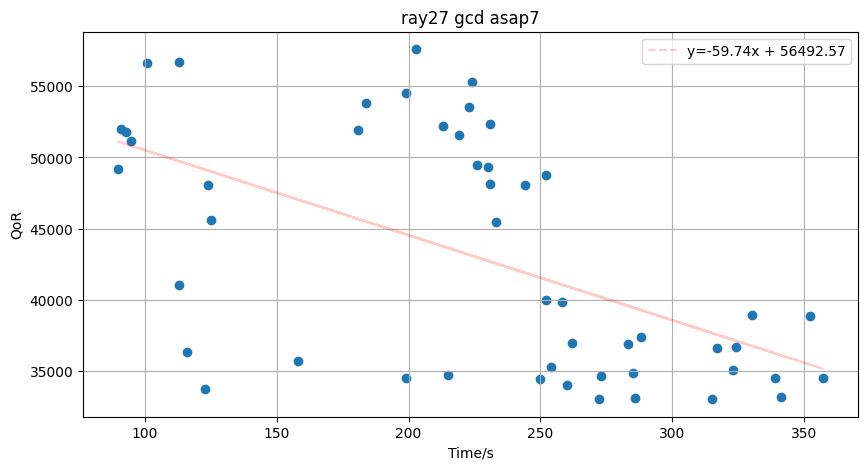

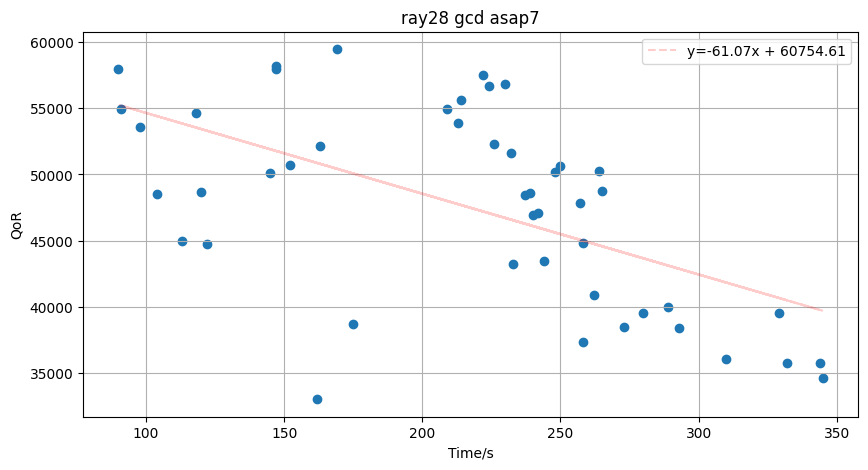

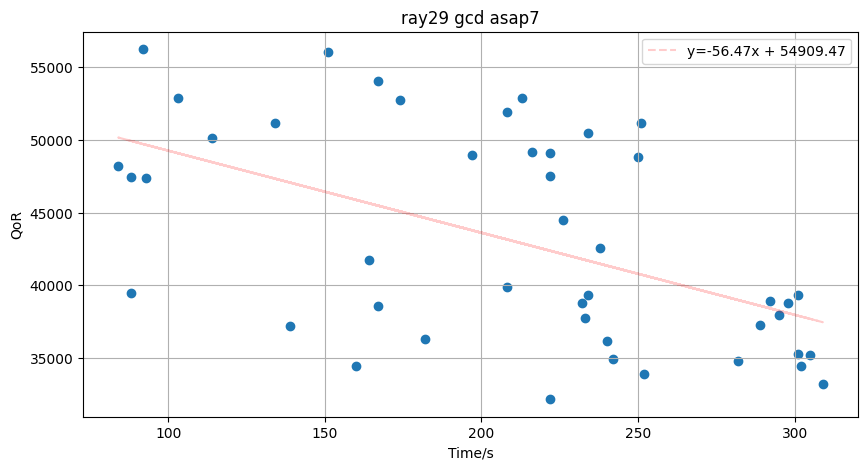

<Figure size 640x480 with 0 Axes>

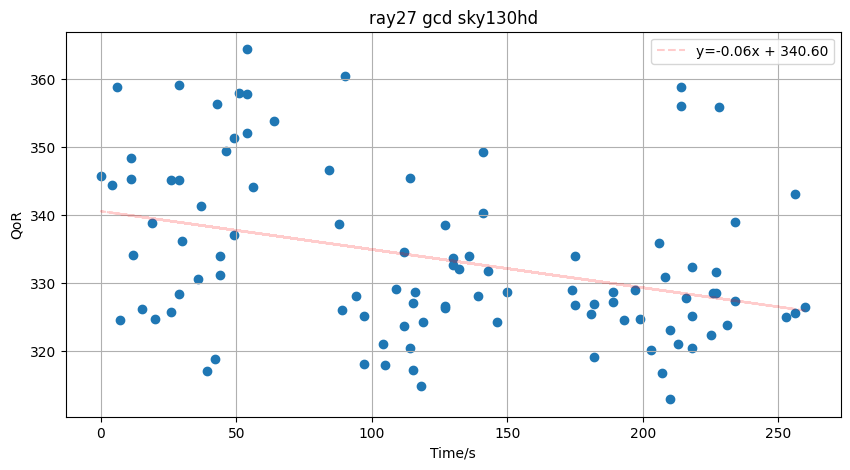

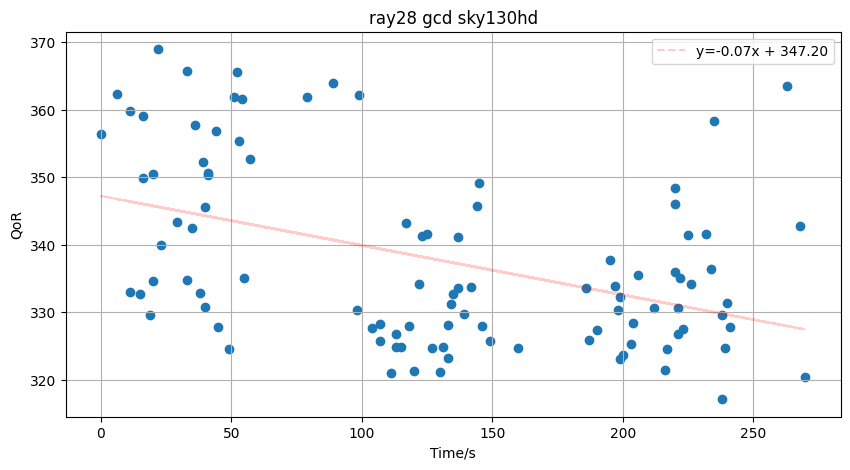

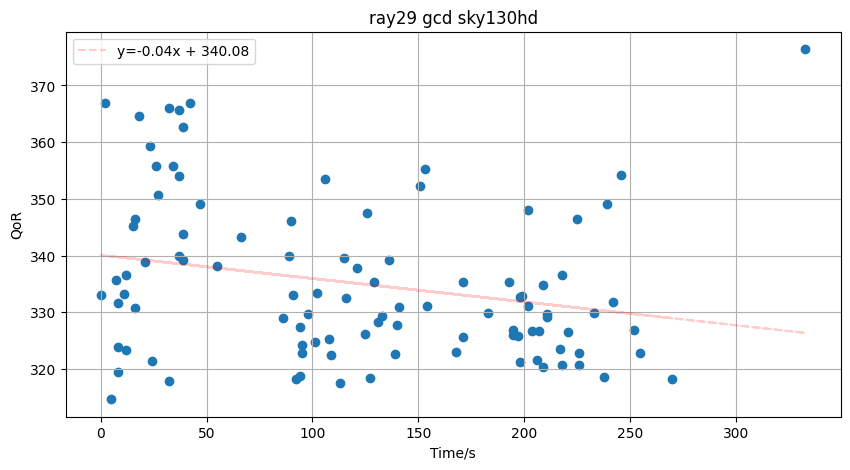

<Figure size 640x480 with 0 Axes>

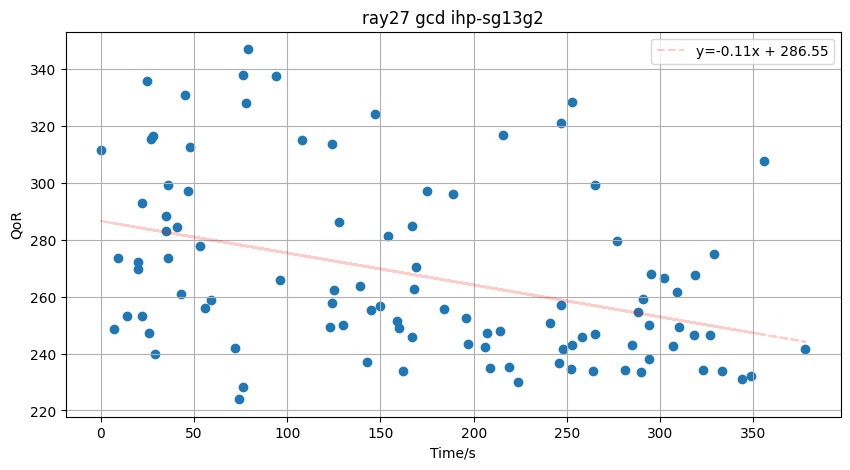

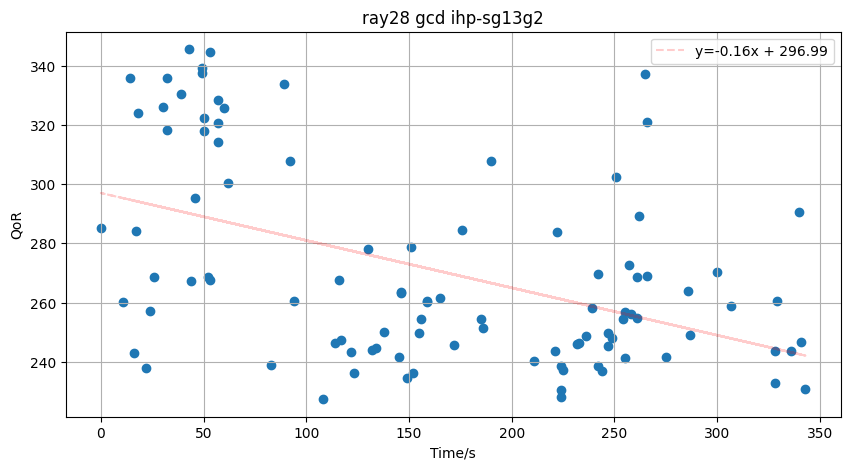

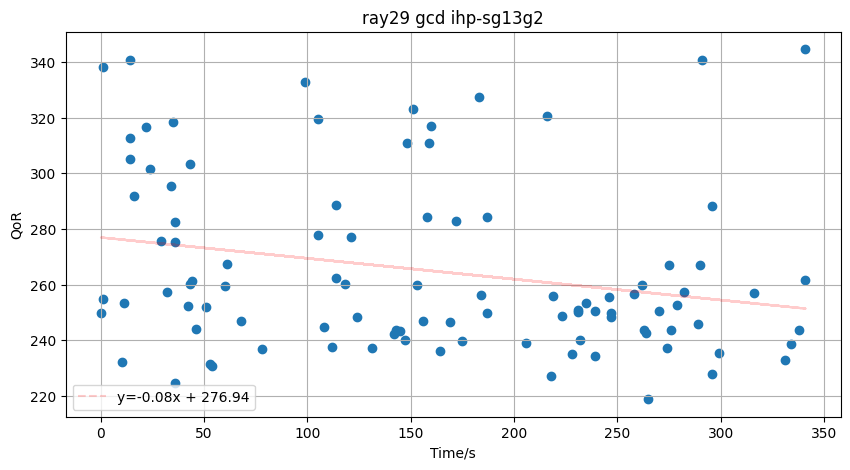

<Figure size 640x480 with 0 Axes>

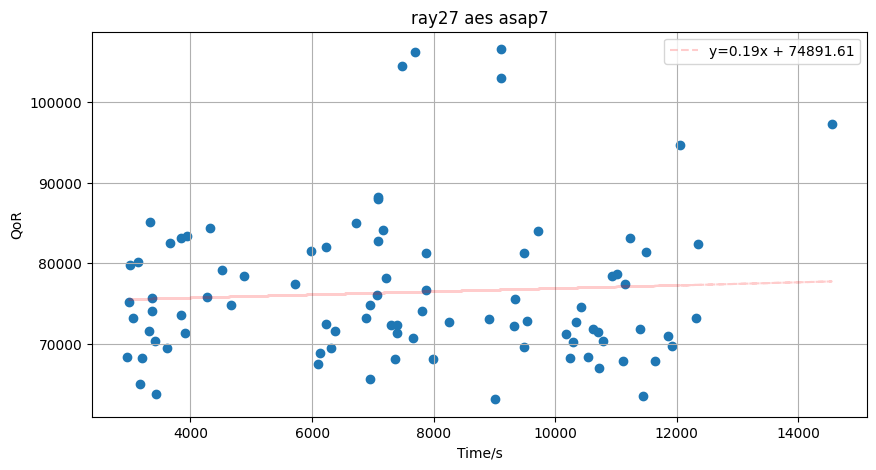

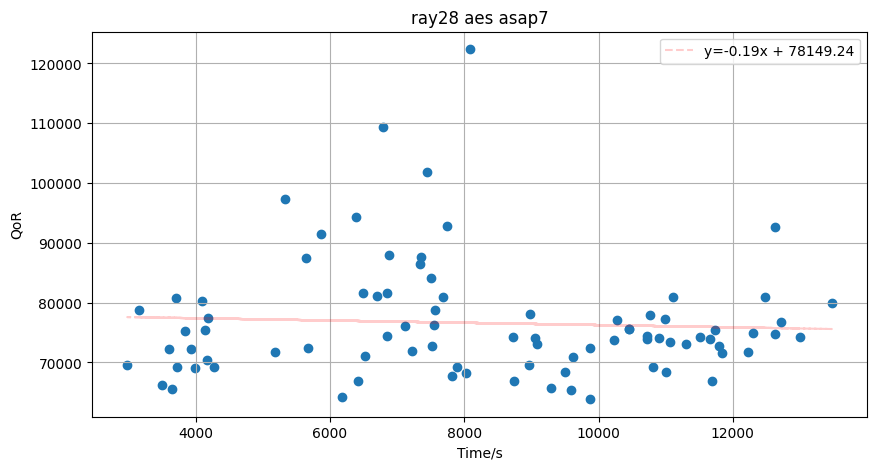

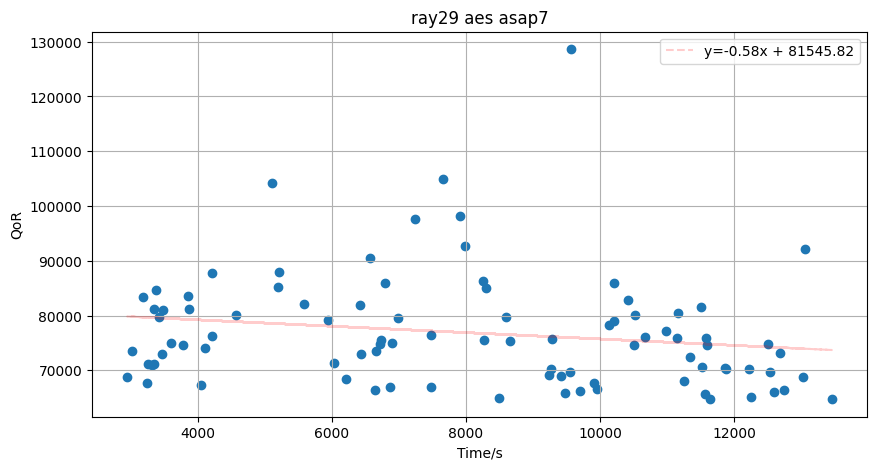

<Figure size 640x480 with 0 Axes>

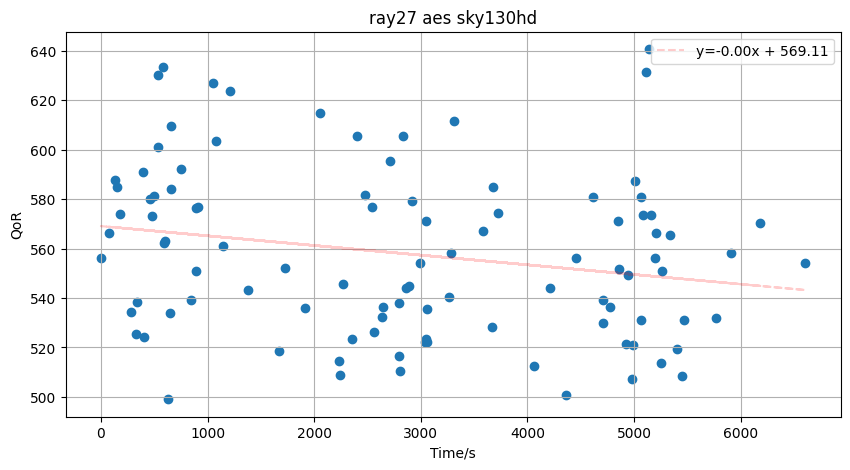

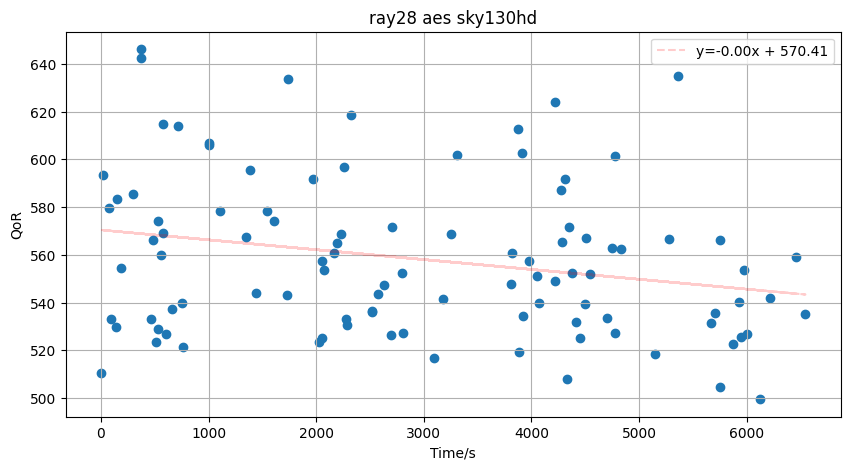

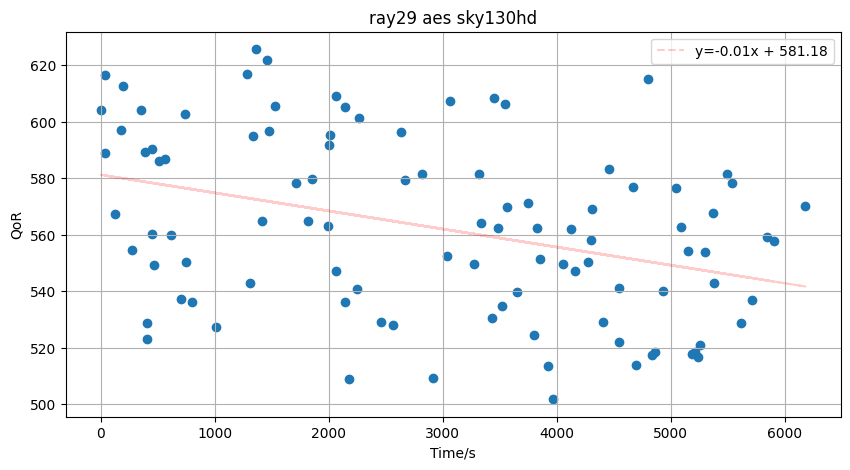

<Figure size 640x480 with 0 Axes>

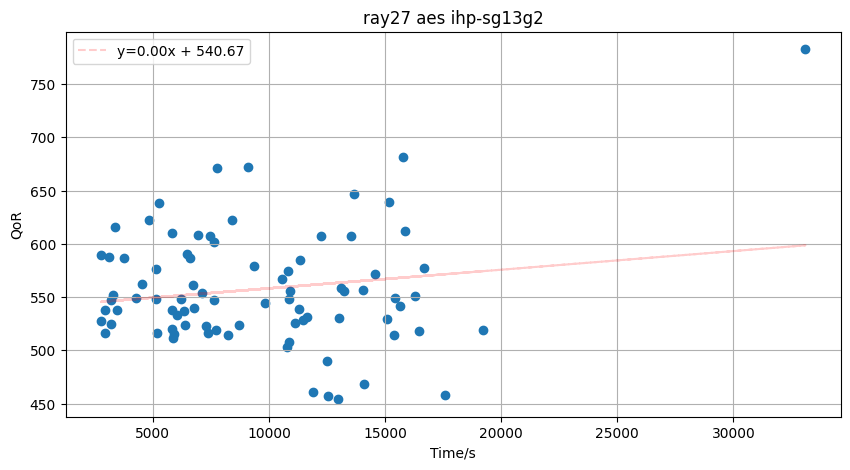

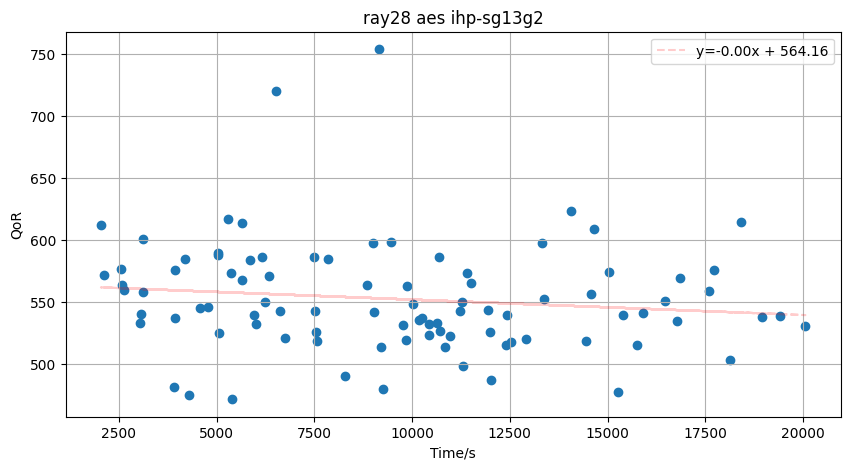

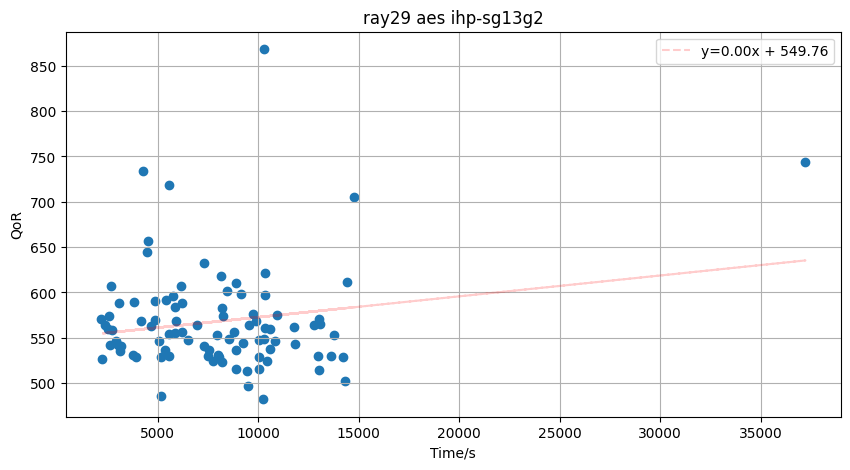

<Figure size 640x480 with 0 Axes>

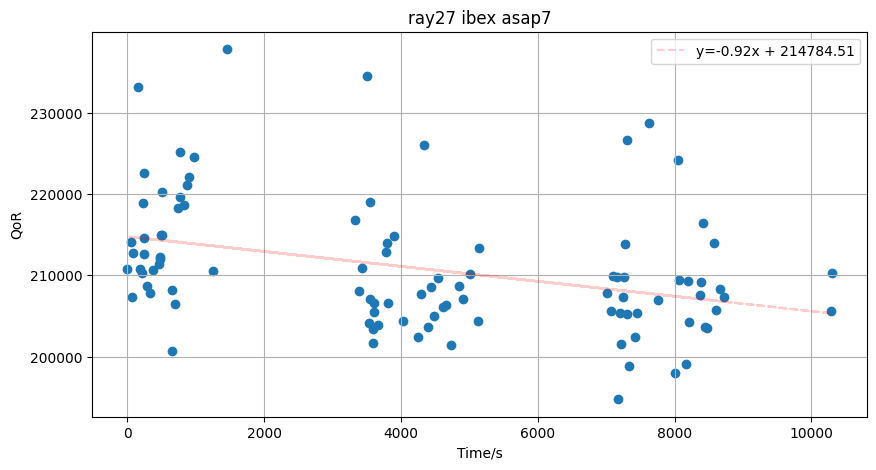

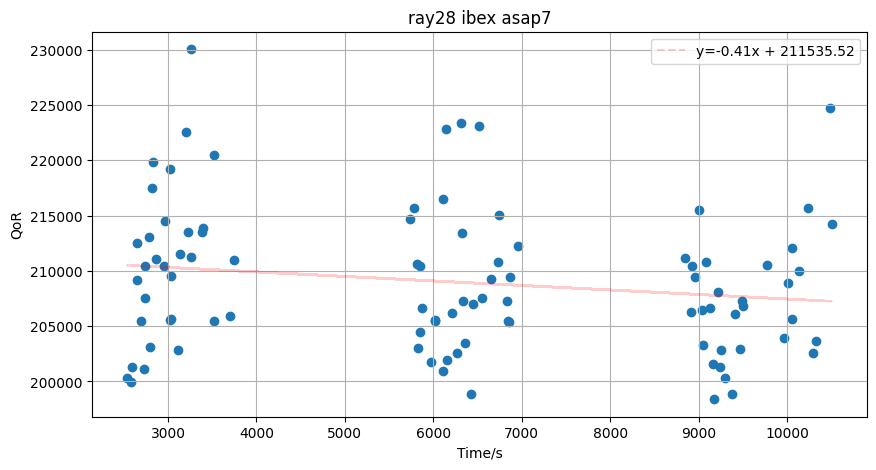

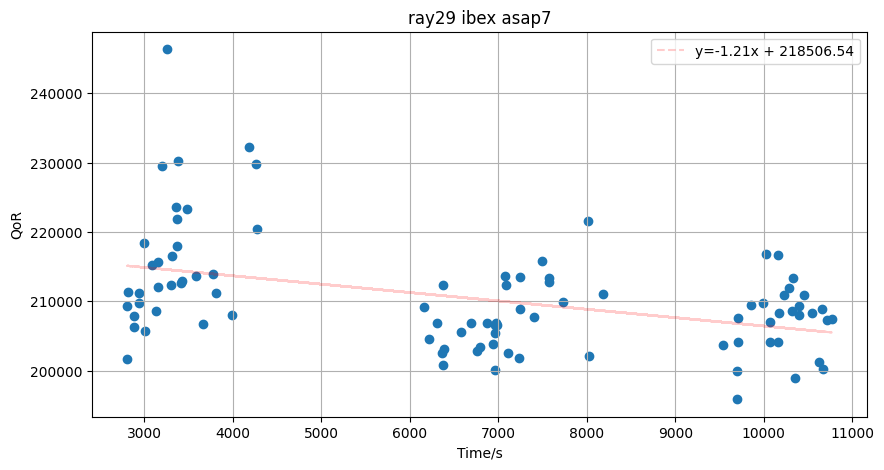

<Figure size 640x480 with 0 Axes>

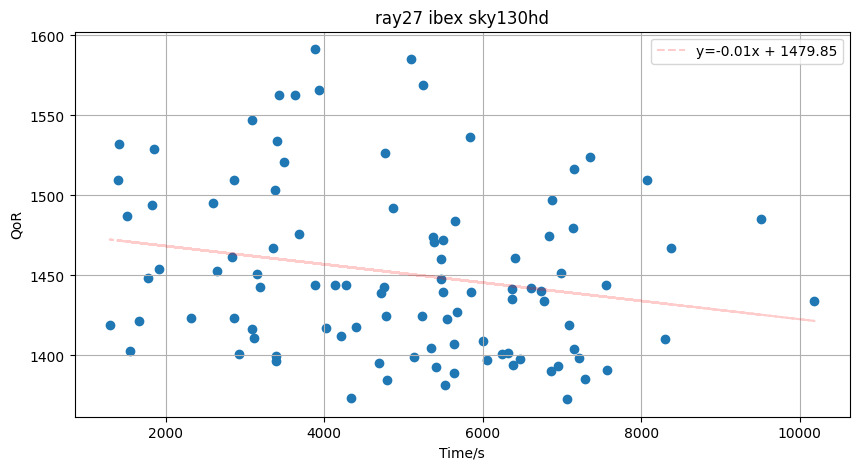

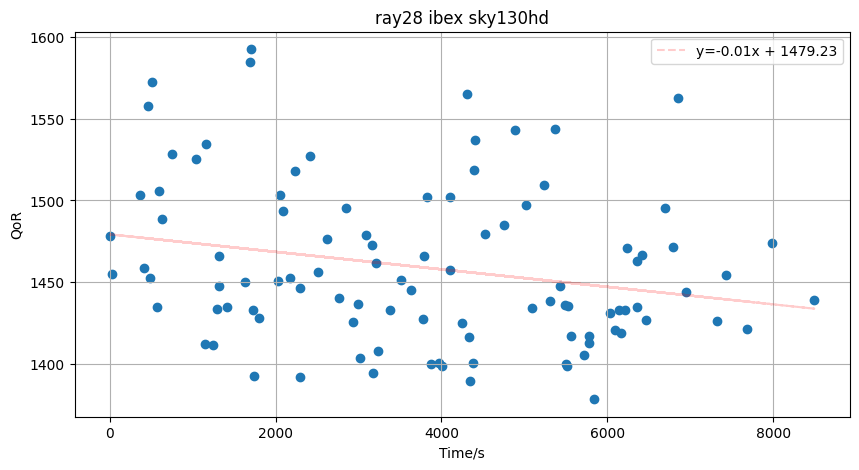

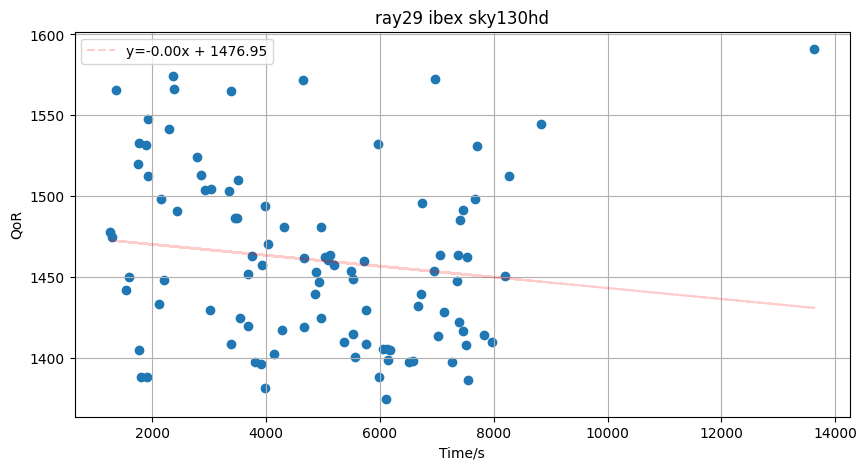

<Figure size 640x480 with 0 Axes>

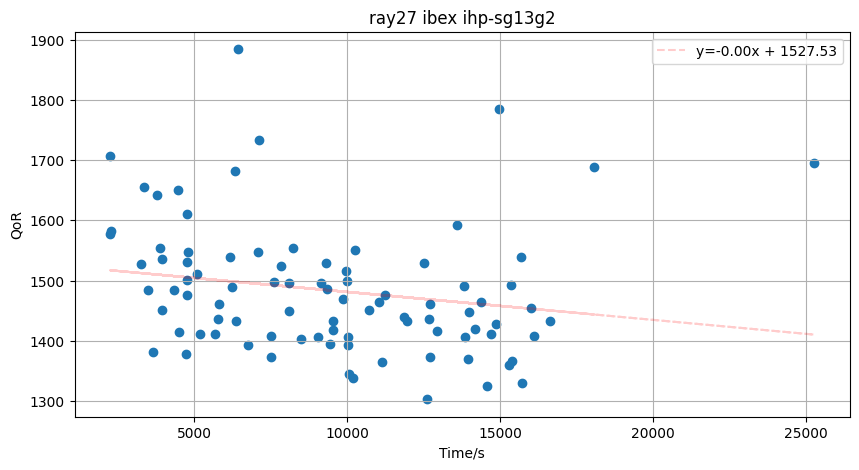

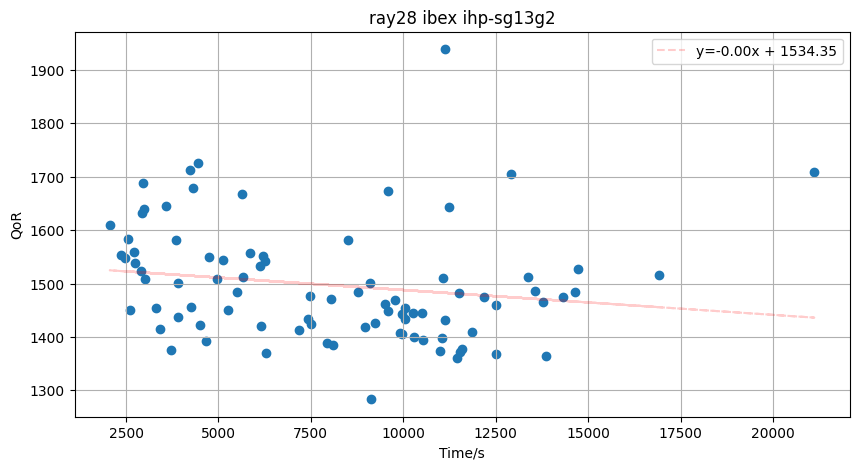

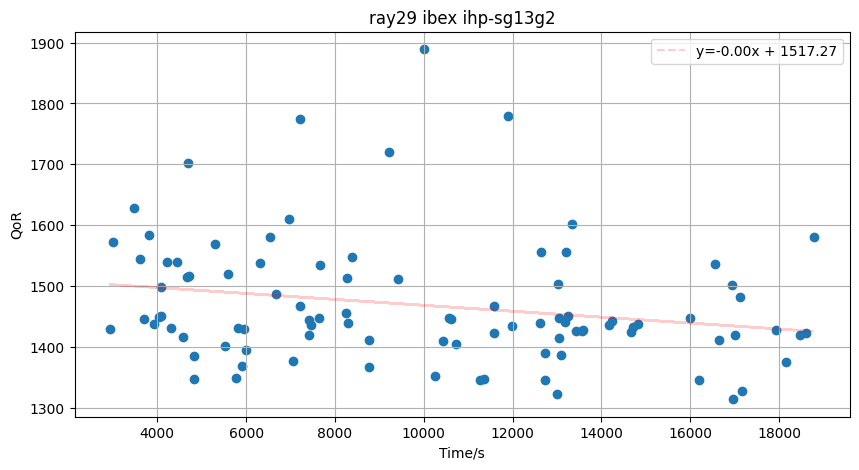

In [5]:
def preprocess(filename):
    cols_to_remove = [
        "done", "training_iteration", "trial_id", "date",
        "pid", "hostname", "node_ip", "time_since_restore",
        "time_total_s", "iterations_since_restore",
    ]
    df = pd.read_csv(filename).drop(columns=cols_to_remove)
    df['timestamp'] = df['timestamp'] - df['timestamp'].min()
    return df[df['minimum'] != 9e99]

def plot_qor(df, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    x, y = df['timestamp'], df['minimum']
    ax.scatter(x, y)
    ax.set_title('QoR versus time')
    ax.set_xlabel('Time/s')
    ax.set_ylabel('QoR')
    ax.grid()
    ax.set_title(title)

    # Plot a linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.2, label=f"y={z[0]:.2f}x + {z[1]:.2f}")
    ax.legend()

# Generate all the plots for the following matrix:
DATE = "20240730"
# DATE="20240809"
for design in ['gcd', 'aes', 'ibex']:
    for platform in ['asap7', 'sky130hd', 'ihp-sg13g2']:
        plt.figure()
        for ray_version in ['ray27', 'ray28', 'ray29']:
            filename = f"{DATE}/{ray_version}-{design}-{platform}.csv"
            df = preprocess(filename)
            plot_qor(df, f"{ray_version} {design} {platform}")


In [14]:
def preprocess_fmax(filename):
    platform, design = filename.split('_')[-1].replace('.csv', ''), filename.split('_')[-2]
    cols_to_remove = [
        "done", "training_iteration", "date",
        "pid", "hostname", "node_ip", "time_since_restore",
        "time_total_s", "iterations_since_restore",
    ]
    df = pd.read_csv(filename).drop(columns=cols_to_remove)
    df['timestamp'] = df['timestamp'] - df['timestamp'].min()
    df = df[df['minimum'] != 9e99]

    # filter df where trial_id length is 8
    df = df[df['trial_id'].apply(lambda x: len(x) == 8)]

    # filter folders that have the trial_ids
    ws_list, period_list = [], []
    for trial_id in df['trial_id']:
        try:
            path = glob.glob(f"../../../../../flow/logs/{platform}/{design}/*/*{trial_id}-ray")[0]
        except:
            print(os.listdir(f"../../../../../flow/logs/{platform}/{design}"))
            print(f"Could not find {trial_id}")
            raise Exception
        expt = json.load(open(f"{path}/metrics.json"))
        ws_list.append(float(expt['finish']['timing__setup__ws']))
        period_list.append(float(expt['constraints']['clocks__details'][0].replace('core_clock: ', '').replace('clk: ', '')))
    assert len(ws_list) == len(period_list), "Length mismatch"
    return df, ws_list, period_list

def plot_fmax(df, period_list, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    x, y = df.timestamp, period_list
    ax.scatter(x, y)
    ax.set_xlabel('time')
    ax.set_ylabel('Period')
    ax.grid()
    ax.set_title(title)

    # Plot a linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.2, label=f"y={z[0]:.2f}x + {z[1]:.2f}")
    ax.legend()

def plot_ws(df, ws_list, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    x, y = df.timestamp, ws_list
    ax.scatter(x, y)
    ax.set_xlabel('time')
    ax.set_ylabel('WS')
    ax.grid()
    ax.set_title(title)

    # Plot a linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.2, label=f"y={z[0]:.2f}x + {z[1]:.2f}")
    ax.legend()


DATE = "20240730"
# DATE="20240809"
for design in ['gcd', 'aes', 'ibex']:
    for platform in ['asap7', 'sky130hd', 'ihp-sg13g2']:
        plt.figure()
        for ray_version in ['ray29']:
            filename = f"{DATE}/{ray_version}-{design}-{platform}.csv"
            print(filename)
            df, ws, period = preprocess_fmax(filename, ray_version, design, platform)
            plot_fmax(df, period, f"{ray_version} {design} {platform}")
            plot_ws(df, ws, f"{ray_version} {design} {platform}")


20240730/ray29_gcd_asap7.csv


FileNotFoundError: [Errno 2] No such file or directory: '20240730/ray29_gcd_asap7.csv'

<Figure size 640x480 with 0 Axes>